In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn import preprocessing
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
class myCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc') > 0.98):
            print("\nReached 99% accuracy so cancelling training!")
            self.model.stop_training = True

In [4]:
df = pd.read_csv("EXTENDED_1.csv",encoding="latin-1")

# Extract features for fashion active peoples
cols = ["CGPA",
              "Sleep duration",
              "Do you start your day by planning(y/n)",
              "Coffee drinker"]
dataset = df[cols].copy()

In [5]:
dataset = dataset.dropna() # clear missing values rows

In [6]:
dataset.head()

,CGPA,Sleep duration,Do you start your day by planning(y/n),Coffee drinker
1,3.48,8.0,No,0.0
2,2.90,8.0,Yes,1.0
3,3.33,6.0,Yes,1.0
4,3.72,8.0,No,0.0
5,3.43,6.0,No,0.0


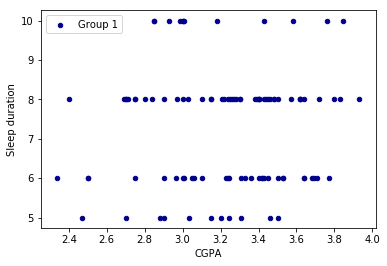

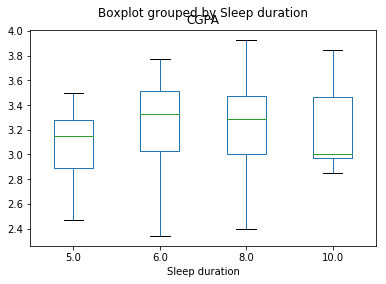

In [7]:
dataset.plot.scatter(x='CGPA', y='Sleep duration', color='DarkBlue', label='Group 1')
dataset.boxplot(by='Sleep duration', column=['CGPA'], grid= False)

In [8]:
# Preprocessing

for i, x in dataset.iterrows():
    if dataset.loc[i, 'CGPA'] > 3.5: # high
        dataset.loc[i, 'CGPA'] = 2
    elif dataset.loc[i, 'CGPA'] > 3.0 and dataset.loc[i, 'CGPA'] < 3.5: # medium
        dataset.loc[i, 'CGPA'] = 1
    else: # low
        dataset.loc[i, 'CGPA'] = 0
        
dataset['Do you start your day by planning(y/n)'] = (dataset['Do you start your day by planning(y/n)'] == 'Yes').astype(float)

dataset.head()

,CGPA,Sleep duration,Do you start your day by planning(y/n),Coffee drinker
1,1.0,8.0,0.0,0.0
2,0.0,8.0,1.0,1.0
3,1.0,6.0,1.0,1.0
4,2.0,8.0,0.0,0.0
5,1.0,6.0,0.0,0.0


In [9]:
# Normalize
x = dataset.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
dataset = pd.DataFrame(x_scaled,columns=cols)

dataset.head()

,CGPA,Sleep duration,Do you start your day by planning(y/n),Coffee drinker
0,0.5,0.6,0.0,0.0
1,0.0,0.6,1.0,1.0
2,0.5,0.2,1.0,1.0
3,1.0,0.6,0.0,0.0
4,0.5,0.2,0.0,0.0


In [10]:
train_dataset = dataset.sample(frac=0.9,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_labels = train_dataset.pop("Coffee drinker")
test_labels = test_dataset.pop("Coffee drinker")

In [11]:
def build_model():
    model = keras.Sequential([
        layers.Dense(100, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1, activation=tf.nn.sigmoid), # binary class => Hardworking or lazy
    ])
    
    model.compile(optimizer= tf.train.AdamOptimizer(),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model

In [12]:
model = build_model()

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
model.summary() # description of the model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                6464      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 6,929
Trainable params: 6,929
Non-trainable params: 0
_________________________________________________________________


In [14]:
callbacks = myCallback()

history = model.fit(train_dataset,train_labels,epochs=20,validation_split=0.1,callbacks=[callbacks])

Train on 81 samples, validate on 9 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
81/81 [==============================] - 1s 7ms/sample - loss: 0.6943 - acc: 0.5679 - val_loss: 0.6954 - val_acc: 0.4444
Epoch 2/20
81/81 [==============================] - 0s 197us/sample - loss: 0.6842 - acc: 0.5432 - val_loss: 0.6852 - val_acc: 0.4444
Epoch 3/20
81/81 [==============================] - 0s 222us/sample - loss: 0.6774 - acc: 0.6049 - val_loss: 0.6771 - val_acc: 0.6667
Epoch 4/20
81/81 [==============================] - 0s 271us/sample - loss: 0.6702 - acc: 0.7284 - val_loss: 0.6704 - val_acc: 0.6667
Epoch 5/20
81/81 [==============================] - 0s 259us/sample - loss: 0.6645 - acc: 0.7284 - val_loss: 0.6636 - val_acc: 0.6667
Epoch 6/20
81/81 [==============================] - 0s 259us/sample - loss: 0.6573 - acc: 0.7284 - val_loss: 0.6565 - val_acc: 0.6667
Epoch 7/20
81/81 [==============================] - 0s 246us/sample - loss: 0.6515 - acc: 0.7284 - val_loss

In [15]:
eval_model = model.evaluate(test_dataset,test_labels)

print('Loss:',eval_model[0],' Accuracy:',eval_model[1])

10/10 [==============================] - 0s 299us/sample - loss: 0.6852 - acc: 0.6000
Loss: 0.6851726770401001  Accuracy: 0.6


In [16]:
test_predictions = model.predict(test_dataset)
test_predictions = (test_predictions > 0.5)

[[5 0]
 [4 1]]


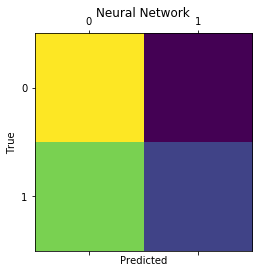

In [17]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, test_predictions)
# print(cm)

def plot_conf_mat(lTrue, lPred, title):
    """ A function for plotting the confusion matrix given true and predicted labels."""
    cm = confusion_matrix(lTrue.astype(int), lPred.astype(int))
    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
plot_conf_mat(test_labels, test_predictions, 'Neural Network')
# Confusion matrix for binary classification
# [[TNeg FPos]
#  [FNeg TPos]]

In [18]:
cols = ['Gender','Wake up time?','Number of programming hours spent per day','Sleep duration','Coffee drinker','Hometown', 'Favorite food names','Weight']
datasetToEval = df[cols]
datasetToEval = datasetToEval.dropna()

In [19]:
for i, x in datasetToEval.iterrows():
    if datasetToEval.loc[i, 'Wake up time?'] == "10:00:00 AM":
        datasetToEval.loc[i, 'Wake up time?'] = 10
    elif datasetToEval.loc[i, 'Wake up time?'] == "9:00:00 AM":
        datasetToEval.loc[i, 'Wake up time?'] = 9
    else:
        datasetToEval.loc[i, 'Wake up time?'] = 8
        
for i, x in datasetToEval.iterrows():
    if datasetToEval.loc[i, 'Hometown'].lower() == "manikgong" or datasetToEval.loc[i, 'Hometown'].lower() == "munshigang" or datasetToEval.loc[i, 'Hometown'].lower() == "narsingdi" or datasetToEval.loc[i, 'Hometown'].lower() == "narsinghdi" or datasetToEval.loc[i, 'Hometown'].lower() == "arambagh,dhaka" or datasetToEval.loc[i, 'Hometown'].lower() == "arambagh" or datasetToEval.loc[i, 'Hometown'].lower() == "arambag" or datasetToEval.loc[i, 'Hometown'].lower() == "bikrompur" or datasetToEval.loc[i, 'Hometown'].lower() == "gopalganj" or  datasetToEval.loc[i, 'Hometown'].lower() == "gopalgonj" or datasetToEval.loc[i, 'Hometown'].lower() == "bikrampur" or datasetToEval.loc[i, 'Hometown'].lower() == "dhaka" or datasetToEval.loc[i, 'Hometown'].lower() == "tangail" or datasetToEval.loc[i, 'Hometown'].lower() == "munshiganj" or datasetToEval.loc[i, 'Hometown'].lower() == "gajipur" or datasetToEval.loc[i, 'Hometown'].lower() == "gazipur" or datasetToEval.loc[i, 'Hometown'].lower() == "kishoregonj" or datasetToEval.loc[i, 'Hometown'].lower() == "kishoreganj" or datasetToEval.loc[i, 'Hometown'].lower() == "kishorgonj" or datasetToEval.loc[i, 'Hometown'].lower() == "kishorganj" or datasetToEval.loc[i, 'Hometown'].lower() == "munshigonj" or datasetToEval.loc[i, 'Hometown'].lower() == "manikgonj" or datasetToEval.loc[i, 'Hometown'].lower() == "manikganj":
        datasetToEval.loc[i, 'Hometown'] = "Dhaka"
    elif datasetToEval.loc[i, 'Hometown'].lower() == "luxmipur" or datasetToEval.loc[i, 'Hometown'].lower() == "laxmipur" or datasetToEval.loc[i, 'Hometown'].lower() == "chittagong" or datasetToEval.loc[i, 'Hometown'].lower() == "lakshmipur" or datasetToEval.loc[i, 'Hometown'].lower() == "noakhali" or datasetToEval.loc[i, 'Hometown'].lower() == "lokkhipur" or datasetToEval.loc[i, 'Hometown'].lower() == "b.baria" or datasetToEval.loc[i, 'Hometown'].lower() == "b. baria" or datasetToEval.loc[i, 'Hometown'].lower() == "brahmanbaria" or datasetToEval.loc[i, 'Hometown'].lower() == "chandpur" or datasetToEval.loc[i, 'Hometown'].lower() == "chaadpur" or datasetToEval.loc[i, 'Hometown'].lower() == "chadpur" or datasetToEval.loc[i, 'Hometown'].lower() == "feni":
        datasetToEval.loc[i, 'Hometown'] = "Chittagong"
    elif datasetToEval.loc[i, 'Hometown'].lower() == "jhenaidah" or datasetToEval.loc[i, 'Hometown'].lower() == "kustia" or datasetToEval.loc[i, 'Hometown'].lower() == "khulna" or datasetToEval.loc[i, 'Hometown'].lower() == "bagerhat" or datasetToEval.loc[i, 'Hometown'].lower() == "kushtia" or datasetToEval.loc[i, 'Hometown'].lower() == "jessore" or datasetToEval.loc[i, 'Hometown'].lower() == "satkhira" or datasetToEval.loc[i, 'Hometown'].lower() == "saatkhira" or datasetToEval.loc[i, 'Hometown'].lower() == "shaatkhira" or datasetToEval.loc[i, 'Hometown'].lower() == "shatkhira" or datasetToEval.loc[i, 'Hometown'].lower() == "pabna":
        datasetToEval.loc[i, 'Hometown'] = "Khulna"
    elif datasetToEval.loc[i, 'Hometown'].lower() == "bogra" or datasetToEval.loc[i, 'Hometown'].lower() == "rajshahi" or datasetToEval.loc[i, 'Hometown'].lower() == "pabna":
        datasetToEval.loc[i, 'Hometown'] = "Rajshahi"
    elif datasetToEval.loc[i, 'Hometown'].lower() == "jamalpur" or datasetToEval.loc[i, 'Hometown'].lower() == "mymensingh" or datasetToEval.loc[i, 'Hometown'].lower() == "mymensing":
        datasetToEval.loc[i, 'Hometown'] = "Mymensingh"
    elif datasetToEval.loc[i, 'Hometown'].lower() == "mymensing" or datasetToEval.loc[i, 'Hometown'].lower() == "barisal":
        datasetToEval.loc[i, 'Hometown'] = "Barisal"
    elif datasetToEval.loc[i, 'Hometown'].lower() == "kurigram, rangpur" or datasetToEval.loc[i, 'Hometown'].lower() == "kurigram" or datasetToEval.loc[i, 'Hometown'].lower() == "gaibandha" or datasetToEval.loc[i, 'Hometown'].lower() == "dianjpur" or datasetToEval.loc[i, 'Hometown'].lower() == "rangpur":
        datasetToEval.loc[i, 'Hometown'] = "Rangpur"
    elif datasetToEval.loc[i, 'Hometown'].lower() == "sylhet":
        datasetToEval.loc[i, 'Hometown'] = "Sylhet"

datasetToEval.groupby('Hometown').count()

datasetToEval.groupby('Gender').count()

,Wake up time?,Number of programming hours spent per day,Sleep duration,Coffee drinker,Hometown,Favorite food names,Weight
Gender,,,,,,,
Female,33,33,33,33,33,33,33
Male,67,67,67,67,67,67,67


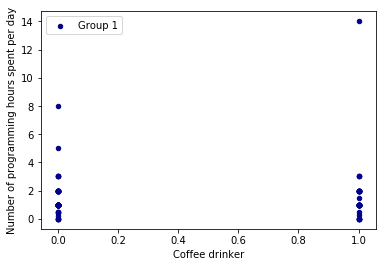

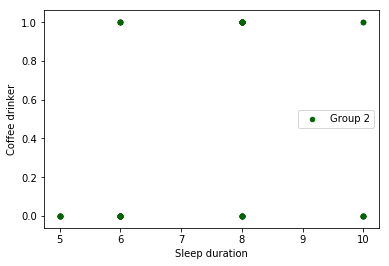

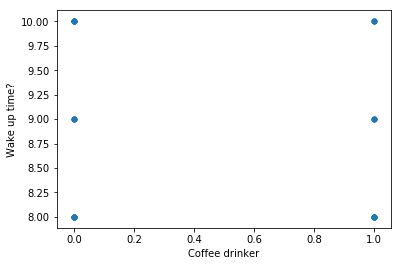

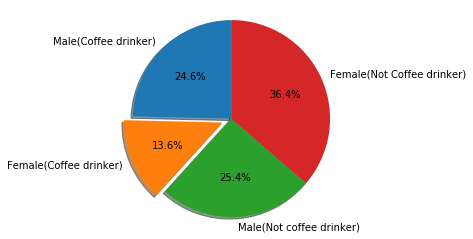

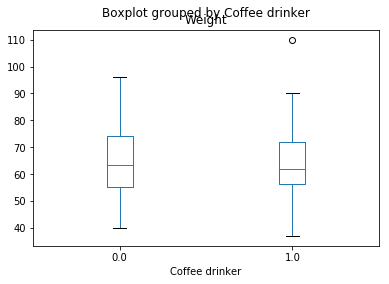

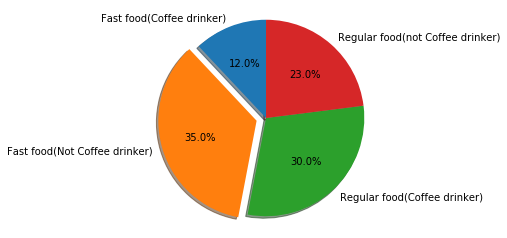

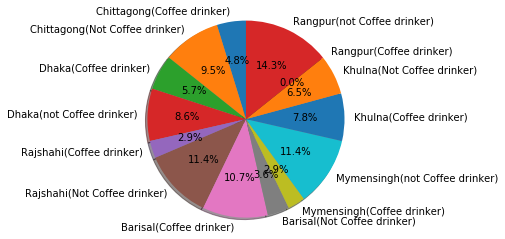

In [23]:
# Correlation
datasetToEval.plot.scatter(x='Coffee drinker', y='Number of programming hours spent per day', color='DarkBlue', label='Group 1')

datasetToEval.plot.scatter(x='Sleep duration', y='Coffee drinker', color='DarkGreen', label='Group 2')

datasetToEval.plot.scatter(x='Coffee drinker', y='Wake up time?', rot=0)


cntMCd = 0
cntFCd = 0
cntMNotCd = 0
cntFNotCd = 0
checkCol = ['Gender','Coffee drinker']

for i, x in datasetToEval.iterrows():
    if datasetToEval.loc[i, checkCol[0]] == "Male" and datasetToEval.loc[i, checkCol[1]] == 1.0:
        cntMCd += 1
    elif datasetToEval.loc[i, checkCol[0]] == "Male" and datasetToEval.loc[i, checkCol[1]] == 0.0:
        cntMNotCd += 1    
    elif datasetToEval.loc[i, checkCol[0]] == "Female" and datasetToEval.loc[i, checkCol[1]] == 1.0:
        cntFCd += 1
    elif datasetToEval.loc[i, checkCol[0]] == "Female" and datasetToEval.loc[i, checkCol[1]] == 0.0:
        cntFNotCd += 1

cntMCd = cntMCd/67
cntMNotCd = cntMNotCd/67
cntFCd = cntFCd/33
cntFNotCd = cntFNotCd/33
labels = 'Male(Coffee drinker)', 'Female(Coffee drinker)', 'Male(Not coffee drinker)', 'Female(Not Coffee drinker)'
sizes = [cntMCd, cntFCd, cntMNotCd, cntFNotCd]
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig('gen.png')
plt.show()

datasetToEval.boxplot(by='Coffee drinker', column=['Weight'], grid= False)

lis = [0] * 4
checkCol = ['Favorite food names','Coffee drinker']

for i, x in datasetToEval.iterrows():
    if datasetToEval.loc[i, checkCol[0]] == "Fast food" and datasetToEval.loc[i, checkCol[1]] == 1.0:
        lis[0] += 1
    elif datasetToEval.loc[i, checkCol[0]] == "Fast food" and datasetToEval.loc[i, checkCol[1]] == 0.0:
        lis[1] += 1
    elif datasetToEval.loc[i, checkCol[0]] == "Regular food" and datasetToEval.loc[i, checkCol[1]] == 1.0:
        lis[2] += 1    
    elif datasetToEval.loc[i, checkCol[0]] == "Regular food" and datasetToEval.loc[i, checkCol[1]] == 0.0:
        lis[3] += 1
    
labels = 'Fast food(Coffee drinker)', 'Fast food(Not Coffee drinker)', 'Regular food(Coffee drinker)', 'Regular food(not Coffee drinker)'

sizes = [lis[0], lis[1], lis[2], lis[3]]

explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('food.png')
plt.show()

loc = [0] * 16
checkCol = ['Hometown','Coffee drinker']

for i, x in datasetToEval.iterrows():
    if datasetToEval.loc[i, checkCol[0]] == "Chittagong" and datasetToEval.loc[i, checkCol[1]] == 1.0:
        loc[0] += 1
    elif datasetToEval.loc[i, checkCol[0]] == "Chittagong" and datasetToEval.loc[i, checkCol[1]] == 0.0:
        loc[1] += 1
    elif datasetToEval.loc[i, checkCol[0]] == "Dhaka" and datasetToEval.loc[i, checkCol[1]] == 1.0:
        loc[2] += 1
    elif datasetToEval.loc[i, checkCol[0]] == "Dhaka" and datasetToEval.loc[i, checkCol[1]] == 0.0:
        loc[3] += 1
    elif datasetToEval.loc[i, checkCol[0]] == "Rajshahi" and datasetToEval.loc[i, checkCol[1]] == 1.0:
        loc[4] += 1
    elif datasetToEval.loc[i, checkCol[0]] == "Rajshahi" and datasetToEval.loc[i, checkCol[1]] == 0.0:
        loc[5] += 1
    elif datasetToEval.loc[i, checkCol[0]] == "Sylhet" and datasetToEval.loc[i, checkCol[1]] == 1.0:
        loc[6] += 1
    elif datasetToEval.loc[i, checkCol[0]] == "Sylhet" and datasetToEval.loc[i, checkCol[1]] == 0.0:
        loc[7] += 1
    elif datasetToEval.loc[i, checkCol[0]] == "Barisal" and datasetToEval.loc[i, checkCol[1]] == 1.0:
        loc[8] += 1
    elif datasetToEval.loc[i, checkCol[0]] == "Barisal" and datasetToEval.loc[i, checkCol[1]] == 0.0:
        loc[9] += 1
    elif datasetToEval.loc[i, checkCol[0]] == "Mymensingh" and datasetToEval.loc[i, checkCol[1]] == 1.0:
        loc[10] += 1
    elif datasetToEval.loc[i, checkCol[0]] == "Mymensingh" and datasetToEval.loc[i, checkCol[1]] == 0.0:
        loc[11] += 1
    elif datasetToEval.loc[i, checkCol[0]] == "Khulna" and datasetToEval.loc[i, checkCol[1]] == 1.0:
        loc[12] += 1
    elif datasetToEval.loc[i, checkCol[0]] == "Khulna" and datasetToEval.loc[i, checkCol[1]] == 0.0:
        loc[13] += 1
    elif datasetToEval.loc[i, checkCol[0]] == "Rangpur" and datasetToEval.loc[i, checkCol[1]] == 1.0:
        loc[14] += 1
    elif datasetToEval.loc[i, checkCol[0]] == "Rangpur" and datasetToEval.loc[i, checkCol[1]] == 0.0:
        loc[15] += 1
br = 4
ch = 21
co = 14
dh = 35
din = 1
khul = 11
mm = 5
raj = 5
rang = 4
loc[0] = loc[0]/ch
loc[1] = loc[1]/ch
loc[2] = loc[2]/dh
loc[3] = loc[3]/dh
loc[4] = loc[4]/raj
loc[5] = loc[5]/raj
loc[8] = loc[8]/br
loc[9] = loc[9]/br
loc[10] = loc[10]/mm
loc[11] = loc[11]/mm
loc[12] = loc[12]/khul
loc[13] = loc[13]/khul
loc[14] = loc[14]/rang
loc[15] = loc[15]/rang

labels = 'Chittagong(Coffee drinker)', 'Chittagong(Not Coffee drinker)', 'Dhaka(Coffee drinker)', 'Dhaka(not Coffee drinker)', 'Rajshahi(Coffee drinker)', 'Rajshahi(Not Coffee drinker)', 'Barisal(Coffee drinker)', 'Barisal(Not Coffee drinker)', 'Mymensingh(Coffee drinker)', 'Mymensingh(not Coffee drinker)', 'Khulna(Coffee drinker)', 'Khulna(Not Coffee drinker)', 'Rangpur(Coffee drinker)', 'Rangpur(not Coffee drinker)'

sizes = [loc[0], loc[1], loc[2], loc[3], loc[4], loc[5], loc[8], loc[9], loc[10], loc[11], loc[12], loc[13], loc[14], loc[15]]

# explode = (0, 0, 0, 0,)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('loc.png')
plt.show()